In [1]:
import torch
from torch.autograd import Variable
from cnn_rnn_config import classes_, cdict_, icdict_, fixed_size
import editdistance
import argparse
from skimage import io as img_io
import numpy as np
from data.iamdataset import IAMDataset, image_resize, centered
import cv2

##### Helper functions

In [2]:
# only works for 2 heads
# TODO: make it work only for RNN head
def inference(model, inputs, gpu_id=0, two_heads=True):
    tdecs_rnn = []
    outputs = []
    for img in inputs:
        # add batch dimension
        img = img.unsqueeze(0)
        img = Variable(img.cuda(gpu_id))
        with torch.no_grad():
            if two_heads:
                output, aux_output = model(img)
            else:
                output = model(img)
        tdec = output.argmax(2).permute(1, 0).cpu().numpy().squeeze()
        tdecs_rnn += [tdec]

    for tdec in tdecs_rnn:
        tt = [v for j, v in enumerate(tdec) if j == 0 or v != tdec[j - 1]]
        dec_transcr = ''.join([icdict_[t] for t in tt]).replace('_', '')
        dec_transcr = dec_transcr.strip()
        outputs += [dec_transcr]
    
    return outputs

###### Calculate Character Error Rate (CER) and Word Error Rate (WER) 

<img src="info/cer.jpg" alt="Character Error Rate" height="100"/>
<img src="info/wer.jpg" alt="Word Error Rate" height="100"/><br/>
<img src="info/explain.jpg" alt="Notation" width="400"/>




In [3]:
def cer_wer(outputs, targets):
    cer, wer = [], []
    cntc, cntw = 0, 0
    for o, t in zip(outputs, targets):
        # calculate CER and WER
        cc = float(editdistance.eval(o, t))
        ww = float(editdistance.eval(o.split(' '), t.split(' ')))
        cntc += len(t)
        cntw +=  len(t.split(' '))
        cer += [cc]
        wer += [ww]

    cer = sum(cer) / cntc
    wer = sum(wer) / cntw
    return cer, wer

In [4]:
def load_model(model_path='./saved_models/cnn_rnn/best_rnn_head.pth', gpu_id=0):
    model = torch.load(model_path)
    model = model.cuda(gpu_id)
    model.eval()
    return model

In [5]:
def preprocess_images(img_paths):
    imgs = []
    for img_path in img_paths:
        img = img_io.imread(img_path)
        img = 1 - img.astype(np.float32) / 255.0
        img = image_resize(img, height=img.shape[0] // 2)
        fheight, fwidth = fixed_size[0], fixed_size[1]
        nheight, nwidth = img.shape[0], img.shape[1]

        nheight, nwidth = max(4, min(fheight-16, nheight)), max(8, min(fwidth-32, nwidth))

        img = image_resize(img, height=int(1.0 * nheight), width=int(1.0 * nwidth))
        img = centered(img, (fheight, fwidth), border_value=0.0)
        img = torch.Tensor(img).float().unsqueeze(0)
        imgs += [img]
    return imgs


In [12]:
def testing(dataset, n_images, model, gpu_id=0, two_heads=True):
    tuples = []
    for i in range(n_images):
        img, target = dataset[i]
        tuples += [(img, target)]
    
    for img, label in tuples:
        label = label.strip()
        img = img.unsqueeze(0)
        outputs = inference(model, img, gpu_id=gpu_id, two_heads=two_heads)
        cer, wer = cer_wer(outputs, [label])
        print('YH: ', outputs[0])
        print('GT: ', label)
        print(f'CER: {cer}, WER: {wer}')
        img = img.squeeze().numpy().astype(np.float32)
        img = 1 - img
        img = img_io.imshow(img)
        img_io.show()
        

In [13]:
def testing_custom_images(image_paths, model, gpu_id=0, two_heads=True):
    imgs = preprocess_images(image_paths)
    outputs = inference(model, imgs, gpu_id, two_heads=two_heads)
    for i, img in enumerate(imgs):
        print('Predicted: ', outputs[i])
        img = img.squeeze().numpy().astype(np.float32)
        img = 1 - img
        img = img_io.imshow(img)
        img_io.axis('off')
        img_io.show()
    

### Inference

In [8]:
model_path = './saved_models/cnn_rnn/best_rnn_head.pth'
gpu_id = 0
model = load_model(model_path, gpu_id)

In [9]:
train_set = IAMDataset(subset='train', fixed_size=fixed_size, transforms=None)
test_set = IAMDataset(subset='test', fixed_size=fixed_size, transforms=None)

100%|██████████| 2915/2915 [00:00<00:00, 1061134.89it/s]


##### Performance on training data

YH:  A MOVE to stop Mr. Gaitskell from
GT:  A MOVE to stop Mr. Gaitskell from
CER: 0.0, WER: 0.0


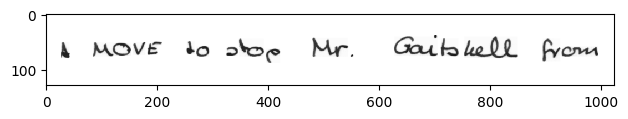

YH:  nominating any more Labour life Peers
GT:  nominating any more Labour life Peers
CER: 0.0, WER: 0.0


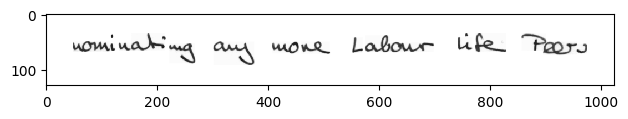

YH:  is to be made at a meeting of Labour
GT:  is to be made at a meeting of Labour
CER: 0.0, WER: 0.0


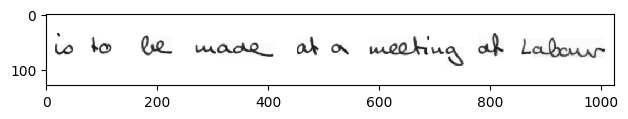

In [14]:
testing(train_set, 3, model, two_heads=False)

##### Performance on test data

YH:  Become a suceswith a dise and hey pres . You're a star. . Ralysmg with
GT:  Become a success with a disc and hey presto ! You're a star ... . Rolly sings with
CER: 0.1951219512195122, WER: 0.5


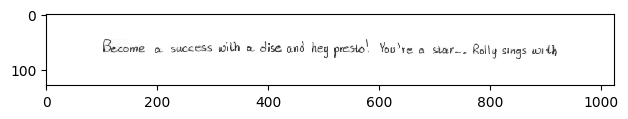

YH:  assurethess " Belle Bela tane " ( Parlophane ) a Wvely song thal chonges tempo mitway .
GT:  assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .
CER: 0.17204301075268819, WER: 0.5555555555555556


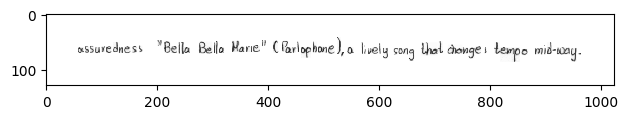

YH:  I donit thinw he will slorm the charls wilth his on , pal i t's a good start .
GT:  I don't think he will storm the charts with this one , but it's a good start .
CER: 0.14102564102564102, WER: 0.5555555555555556


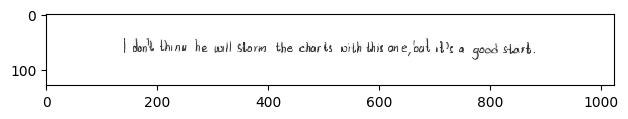

In [16]:
testing(test_set, 3, model, two_heads=False)